Clasificador de Imágenes 

Rafael Mercado Garduño

A01746991


Contexto:
Detectar plátanos y mangos en buen estado es crucial para garantizar la calidad y seguridad de los productos en la cadena de suministro, desde los productores hasta los consumidores. Al identificar frutas maduras y en óptimas condiciones, se minimizan pérdidas y se optimizan los procesos de almacenamiento y distribución. Además, ayuda a satisfacer la demanda de productos frescos, mejora la experiencia del consumidor y contribuye a reducir el desperdicio de alimentos.

In [150]:
import os
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer
from sklearn.metrics import confusion_matrix, classification_report

Este bloque de código importa bibliotecas esenciales para la clasificación de imágenes de plátanos y mangos. Usa `os` y `glob` para gestionar archivos, `cv2` y `PIL` para manipular imágenes, y `matplotlib` para visualizarlas. Además, importa componentes de Keras para construir y entrenar una red neuronal convolucional, así como métricas de sklearn para evaluar el rendimiento del modelo.

In [151]:
train_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Train'
val_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Val'
test_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Test'

Se definen las rutas de los conjuntos de datos de entrenamiento, validación y prueba para la clasificación de plátanos y mangos. El data set se saco de kaggle (https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten) y se separo en proporción 70,20,10 equitativamente cada fruta

In [152]:
def get_images(path, label_map, img_size=(150, 150)):
    X, y = [], []
    for folder in os.listdir(path):
        if folder not in label_map:
            continue 
        folder_path = os.path.join(path, folder)
        images = glob.glob(os.path.join(folder_path, '*.[jp][pn]g'))
        for image in images:
            try:
                image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
                if image_array is None:
                    pil_image = Image.open(image).convert("L")
                    image_array = np.array(pil_image)
                image_array = cv2.resize(image_array, img_size) / 255.0
                image_array = np.expand_dims(image_array, axis=-1)
                X.append(image_array)
                y.append(label_map[folder])
            except Exception as e:
                print(f"Warning: Could not read image {image}. Error: {e}")
    return np.array(X), np.array(y)

label_map = {
    'Banana_Healthy': 0,
    'Banana_Rotten': 1,
    'Mango_Healthy': 2,
    'Mango_Rotten': 3
}

La función `get_images`, carga imágenes de una ruta específica y las etiqueta de acuerdo con un mapa de etiquetas (`label_map`). Itera sobre carpetas de frutas, lee imágenes en escala de grises, las redimensiona a un tamaño definido (`img_size`), y normaliza sus valores. Si hay problemas al leer una imagen, muestra un mensaje de advertencia; finalmente, devuelve las matrices de características (`X`) y etiquetas (`y`) en formato de `numpy`.

In [153]:
X_train, y_train = get_images(train_path, label_map)
X_val, y_val = get_images(val_path, label_map)
X_test, y_test = get_images(test_path, label_map)

En esta parte del código se cargan las imágenes y etiquetas para los conjuntos de datos de entrenamiento, validación y prueba, utilizando la función `get_images` previamente definida. Asigna las imágenes y etiquetas resultantes a las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test` y `y_test`, respectivamente.

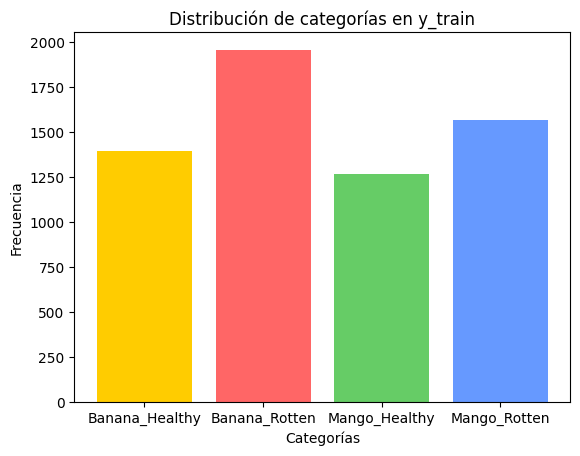

In [154]:
counts = Counter(y_train)
colors = ['#FFCC00', '#FF6666', '#66CC66', '#6699FF'] 
plt.bar(counts.keys(), counts.values(), color=colors, tick_label=list(label_map.keys()))
plt.xlabel("Categorías")
plt.ylabel("Frecuencia")
plt.title("Distribución de categorías en y_train")
plt.show()

Se usa `Counter` para contar la frecuencia de cada categoría en `y_train` y crea un gráfico de barras para visualizar la distribución de las etiquetas y usa `plt.bar` para graficar la cantidad de ejemplos por clase, asignando etiquetas a cada categoría

In [155]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,)
data_gen.fit(X_train)

Aplica transformaciones como volteo horizontal, rotación, zoom, y desplazamientos en anchura y altura, lo que ayuda a aumentar la variabilidad del conjunto de datos y mejorar la generalización del modelo. Finalmente, el generador se ajusta a X_train para preparar las imágenes aumentadas para el entrenamiento del modelo.

In [156]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax') 
])
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

C:\Users\rmerc\PycharmProjects\Frutas\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,852 (26.00 MB)

 Trainable params: 6,813,892 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

El primer modelo usa una arquitectura que incluye capas convolucionales (`Conv2D`) con funciones de activación ReLU, capas de normalización por lotes (`BatchNormalization`) y capas de max-pooling (`MaxPooling2D`) para reducir la dimensionalidad. Luego, las características son aplanadas y se pasa a una capa densa con 512 unidades antes de la capa de salida con 4 neuronas (una para cada categoría), que usa activación softmax para la clasificación multicategórica. El modelo se compila con el optimizador Adam y la función de pérdida de entropía cruzada categórica, y su estructura se resume con `model_1.summary()`.

In [157]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_1.fit(data_gen.flow(X_train, y_train, batch_size=16), epochs=15, validation_data=(X_val, y_val))

Epoch 1/15


C:\Users\rmerc\PycharmProjects\Frutas\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


387/387 ━━━━━━━━━━━━━━━━━━━━ 95s 235ms/step - accuracy: 0.5963 - loss: 5.1200 - val_accuracy: 0.3881 - val_loss: 2.6348
Epoch 2/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 95s 246ms/step - accuracy: 0.7314 - loss: 0.8478 - val_accuracy: 0.7728 - val_loss: 0.6816
Epoch 3/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 88s 227ms/step - accuracy: 0.7570 - loss: 0.7627 - val_accuracy: 0.7874 - val_loss: 0.5397
Epoch 4/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 109s 281ms/step - accuracy: 0.7870 - loss: 0.5919 - val_accuracy: 0.8425 - val_loss: 0.4145
Epoch 5/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 113s 291ms/step - accuracy: 0.8121 - loss: 0.5180 - val_accuracy: 0.8245 - val_loss: 0.5708
Epoch 6/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.8203 - loss: 0.5324 - val_accuracy: 0.8268 - val_loss: 0.4823
Epoch 7/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 122s 316ms/step - accuracy: 0.8187 - loss: 0.5505 - val_accuracy: 0.8358 - val_loss: 0.4897
Epoch 8/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - accuracy: 0.8403 - loss: 0.4687 -

El modelo se entrena durante 15 épocas utilizando el generador de datos (`data_gen`) con el conjunto de entrenamiento, y se evalúa su rendimiento en el conjunto de validación. 

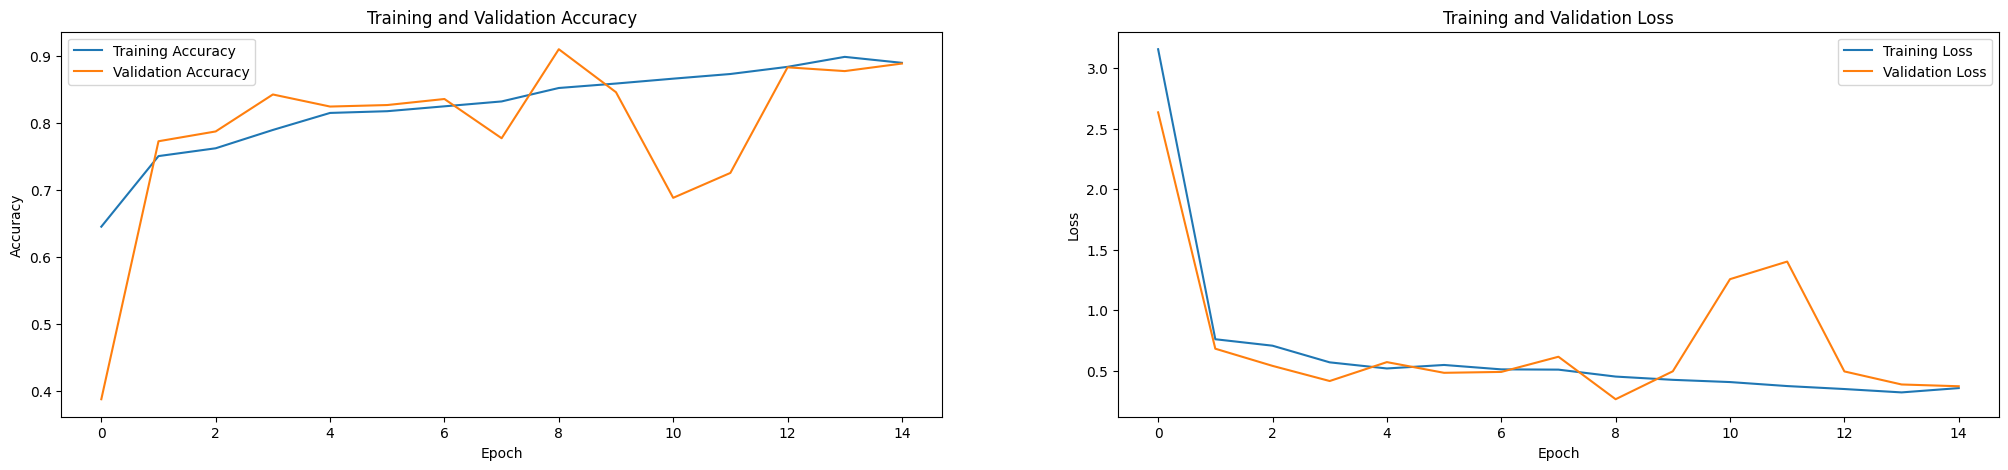

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='best')
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='best')
plt.show()

A la izquierda, se observa cómo la precisión de entrenamiento y validación tiende a mejorar conforme avanza el entrenamiento, indicando que el modelo está aprendiendo a clasificar mejor. A la derecha, la pérdida disminuye en ambos conjuntos, aunque con algunas fluctuaciones en el conjunto de validación, lo cual es normal y puede reflejar la variabilidad en los datos de validación. 

In [159]:
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step


Se generan las predicciones del modelo model_1 sobre el conjunto de prueba X_test. La función predict produce probabilidades para cada clase, y luego np.argmax se utiliza para convertir estas probabilidades en etiquetas de clase (índices de la clase con la mayor probabilidad) para cada imagen de prueba. 

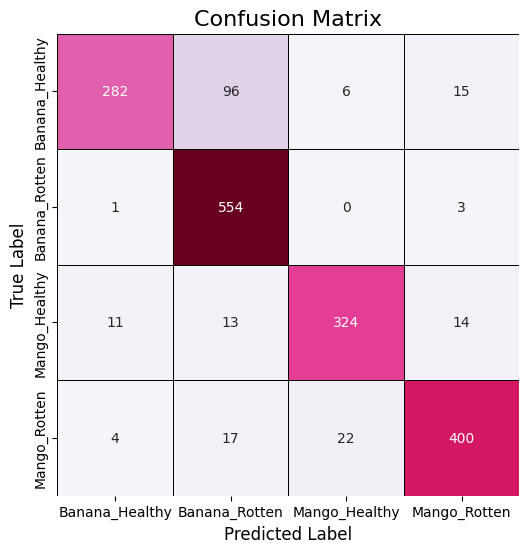

                precision    recall  f1-score   support

Banana_Healthy       0.95      0.71      0.81       399
 Banana_Rotten       0.81      0.99      0.89       558
 Mango_Healthy       0.92      0.90      0.91       362
  Mango_Rotten       0.93      0.90      0.91       443

      accuracy                           0.89      1762
     macro avg       0.90      0.87      0.88      1762
  weighted avg       0.89      0.89      0.88      1762



In [160]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd', cbar=False, 
            linewidths=0.5, linecolor='black', square=True,
            xticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'],
            yticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
print(classification_report(y_test, y_pred, target_names=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']))

El modelo tiene una precisión general del 89%, mostrando buen rendimiento al clasificar mangos, pero confunde algunas bananas sanas con otras categorías, resultando en un recall más bajo (0.71) para esta clase. Las bananas podridas son correctamente identificadas la mayoría de las veces (recall de 0.99), pero otras clases se confunden con esta categoría en algunos casos. En resumen, el modelo funciona bien, aunque puede necesitar mejoras para distinguir mejor entre bananas sanas y podridas.

Mejorar el modelo

In [161]:
model_m = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax') 
])
model_m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_m.summary()

C:\Users\rmerc\PycharmProjects\Frutas\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,053,892 (72.68 MB)

 Trainable params: 19,053,892 (72.68 MB)

 Non-trainable params: 0 (0.00 B)

En comparación con el modelo anterior, el nuevo modelo (model_m) tiene menos capas convolucionales y de normalización por lotes, y utiliza un número menor de filtros iniciales (64 en lugar de 32). También se elimina la capa Dropout para regularización. Esto resulta en una arquitectura más compacta, con un total de 19 millones de parámetros, frente a los 6.8 millones del modelo anterior, lo cual sugiere que el modelo es ahora más complejo y puede requerir más capacidad de procesamiento, pero podría mejorar su capacidad de aprendizaje.

In [162]:
model_m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model_m.fit(data_gen.flow(X_train, y_train, batch_size=32), epochs=22, validation_data=(X_val, y_val))

Epoch 1/22


C:\Users\rmerc\PycharmProjects\Frutas\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.5209 - loss: 1.0385 - val_accuracy: 0.7334 - val_loss: 0.6683
Epoch 2/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 71s 368ms/step - accuracy: 0.7530 - loss: 0.6111 - val_accuracy: 0.7818 - val_loss: 0.5473
Epoch 3/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 72s 371ms/step - accuracy: 0.8328 - loss: 0.4398 - val_accuracy: 0.8976 - val_loss: 0.2856
Epoch 4/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 78s 400ms/step - accuracy: 0.8665 - loss: 0.3512 - val_accuracy: 0.9336 - val_loss: 0.2126
Epoch 5/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 68s 348ms/step - accuracy: 0.8822 - loss: 0.3232 - val_accuracy: 0.9381 - val_loss: 0.1772
Epoch 6/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 73s 378ms/step - accuracy: 0.8973 - loss: 0.2695 - val_accuracy: 0.9348 - val_loss: 0.1833
Epoch 7/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 382ms/step - accuracy: 0.9201 - loss: 0.2320 - val_accuracy: 0.9336 - val_loss: 0.1644
Epoch 8/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 388ms/step - accuracy: 0.9112 - loss: 0.2499 - val

En comparación con el modelo anterior, model_m muestra una precisión y pérdida significativamente mejores en ambos conjuntos (entrenamiento y validación), alcanzando casi un 97% de precisión en validación, mientras que el modelo anterior rondaba el 89%. Este aumento en el rendimiento puede atribuirse a la mayor cantidad de parámetros en model_m, lo que le permite capturar más características de las imágenes. También se cambio el número de epocas a 22 y el batch a 32

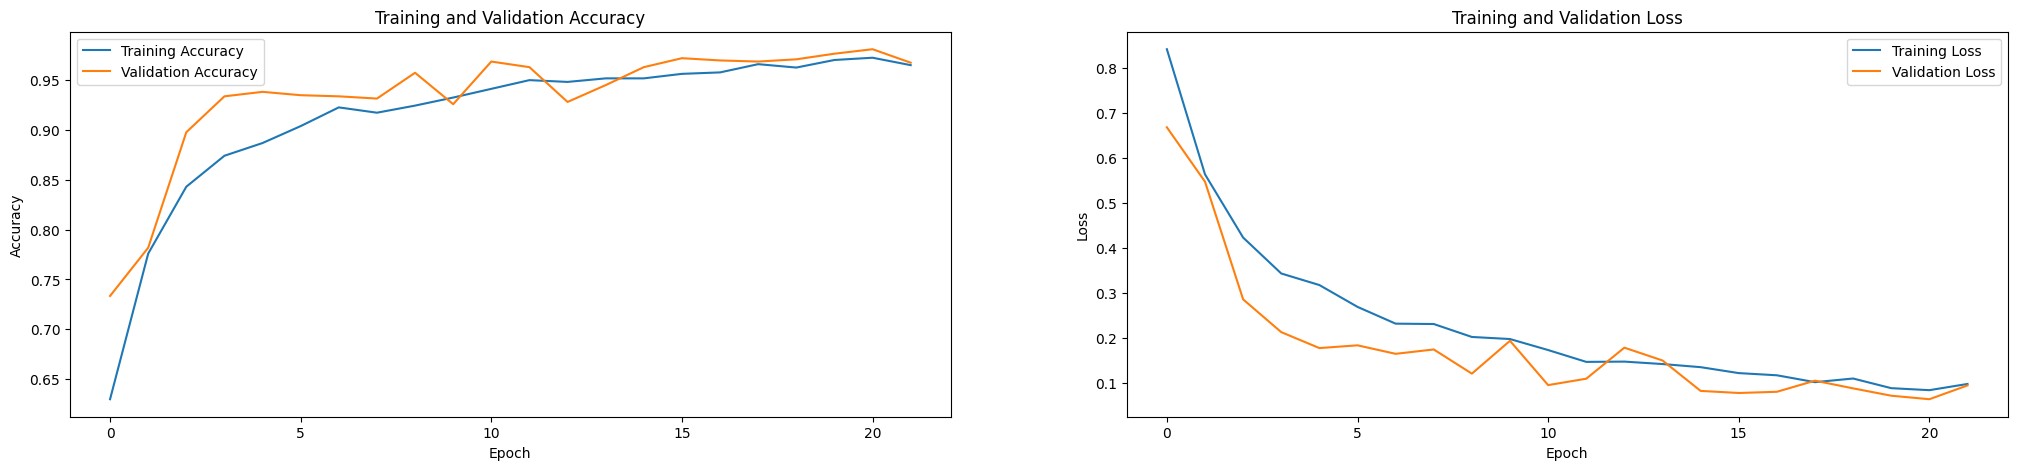

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].plot(history2.history['accuracy'], label='Training Accuracy')
axs[0].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='best')
axs[1].plot(history2.history['loss'], label='Training Loss')
axs[1].plot(history2.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='best')
plt.show()

En comparación con el modelo anterior, model_m muestra una mejora notable en precisión y estabilidad tanto en los conjuntos de entrenamiento como de validación, alcanzando cerca del 97% en ambos sin una gran divergencia entre ellos. Mientras que el modelo anterior mostraba fluctuaciones y un rendimiento más bajo (alrededor del 89% en validación), model_m presenta una curva más suave y consistente en pérdida y precisión, lo que indica que el modelo es más efectivo y generaliza mejor. Esto sugiere que, aunque model_m es más complejo, está bien regularizado y aprovecha mejor su capacidad para clasificar las imágenes con mayor precisión.

In [164]:
y_pred2 = model_m.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


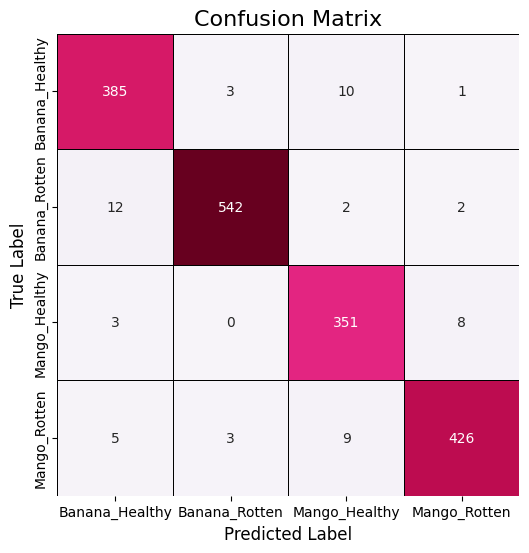

                precision    recall  f1-score   support

Banana_Healthy       0.95      0.96      0.96       399
 Banana_Rotten       0.99      0.97      0.98       558
 Mango_Healthy       0.94      0.97      0.96       362
  Mango_Rotten       0.97      0.96      0.97       443

      accuracy                           0.97      1762
     macro avg       0.96      0.97      0.97      1762
  weighted avg       0.97      0.97      0.97      1762



In [165]:
conf_matrix = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd', cbar=False, 
            linewidths=0.5, linecolor='black', square=True,
            xticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'],
            yticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
print(classification_report(y_test, y_pred2, target_names=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']))

En comparación con el modelo anterior, model_m muestra una mejora significativa en la precisión, recall y f1-score en todas las categorías, alcanzando una precisión global del 97%. La matriz de confusión indica que los errores se redujeron considerablemente, con muy pocas confusiones entre clases. Esto sugiere que el modelo es ahora más eficaz en distinguir entre frutas sanas y podridas, especialmente en la categoría Banana_Healthy, que antes tenía un recall más bajo. En general, model_m demuestra un rendimiento más robusto y consistente en la clasificación de todas las clases.

In [166]:
model_m.save('model.keras')

Se guardó el modelo model_m como model.keras porque demostró ser el mejor en rendimiento, alcanzando una alta precisión del 97% y mostrando consistencia en la clasificación de todas las categorías. 

In [167]:
def clasificar_imagen(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: No se pudo cargar la imagen desde {image_path}. Verifica la ruta.")
        return None
    image = cv2.resize(image, (150, 150))
    image = image / 255.0
    image = np.expand_dims(image, axis=(0, -1))
    prediction = model.predict(image)
    class_index = np.argmax(prediction, axis=1)[0]  
    class_labels = ['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']
    return class_labels[class_index]

Esta función, clasificar_imagen, toma la ruta de una imagen y un modelo como entrada para predecir la clase de la fruta en la imagen. Lee la imagen en escala de grises y la redimensiona a 150x150 píxeles, normalizando los valores de los píxeles. Luego, expande las dimensiones para que coincidan con el formato esperado por el modelo, hace una predicción, y obtiene el índice de la clase con mayor probabilidad. Finalmente, devuelve la etiqueta de la clase correspondiente (Banana_Healthy, Banana_Rotten, Mango_Healthy, o Mango_Rotten).

In [168]:
img_path = r'C:\Users\rmerc\PycharmProjects\Frutas\Platano malo.jpg'
img = clasificar_imagen(img_path, model_m)
img_path2 = r'C:\Users\rmerc\PycharmProjects\Frutas\Mango Bueno.jpg'
img2 = clasificar_imagen(img_path2, model_m)
print("Eso es", img)
print("Eso es", img2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Eso es Banana_Rotten
Eso es Mango_Healthy


En este caso, la primera imagen corresponde a un plátano no saludable y la segunda a un mango saludable. Según los resultados previos del modelo, model_m clasifica de forma muy precisa los plátanos no saludables (Banana_Rotten), lo cual es una fortaleza del modelo, mientras que la clase de mango saludable (Mango_Healthy) es una de las categorías con una ligera menor precisión en comparación con las demás. Por lo tanto, este ejercicio de clasificación muestra tanto una de las clases mejor clasificadas por el modelo como una de las que presenta más desafíos.

El código desarrollado implementa un modelo de clasificación de imágenes que identifica con alta precisión el estado de plátanos y mangos, diferenciando entre frutas saludables y no saludables. Tras entrenar y evaluar el modelo, se demostró que model_m clasifica especialmente bien los plátanos podridos, mientras que tiene un leve desafío con los mangos saludables